# 实验5 图像修复

## 5-1 噪声图像生成及其直方图

### 要求1

噪声图像的生成（Rayleigh噪声，高斯噪声，椒盐噪声+高斯噪声）；

In [1]:
import numpy as np
import cv2
import random


def generate_rayleigh_noise_image(shape, scale, base_image):
    noise = np.random.rayleigh(scale, shape)
    img = base_image + noise
    img = np.clip(img, 0, 255)
    return img


def generate_gaussian_noise_image(shape, mean, std_dev, base_image):
    noise = np.random.normal(mean, std_dev, shape)
    img = base_image + noise
    img = np.clip(img, 0, 255)
    return img


def generate_salt_and_pepper_noise_image(shape, salt_prob, pepper_prob, base_image):
    img = np.copy(base_image)
    height, width = shape

    # 根据概率计算盐和胡椒像素的数量
    num_salt_pixels = int(height * width * salt_prob)
    num_pepper_pixels = int(height * width * pepper_prob)

    # 生成盐噪声
    for _ in range(num_salt_pixels):
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        img[y, x] = 255

    # 生成胡椒噪声
    for _ in range(num_pepper_pixels):
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        img[y, x] = 0

    return img


base_image = cv2.imread("imgs/Lab5/test-pattern.tif", cv2.IMREAD_GRAYSCALE)
height, width = base_image.shape

# 噪声参数
scale = 25
mean = 3
std_dev = 15
salt_prob = 0.3
pepper_prob = 0.3

# 生成三种噪声图像
rayleigh_noise_image = generate_rayleigh_noise_image((height, width), scale, base_image)
gaussian_noise_image = generate_gaussian_noise_image(
    (height, width), mean, std_dev, base_image
)
salt_and_pepper_noise_image = generate_salt_and_pepper_noise_image(
    (height, width), salt_prob, pepper_prob, base_image
)

显示图像

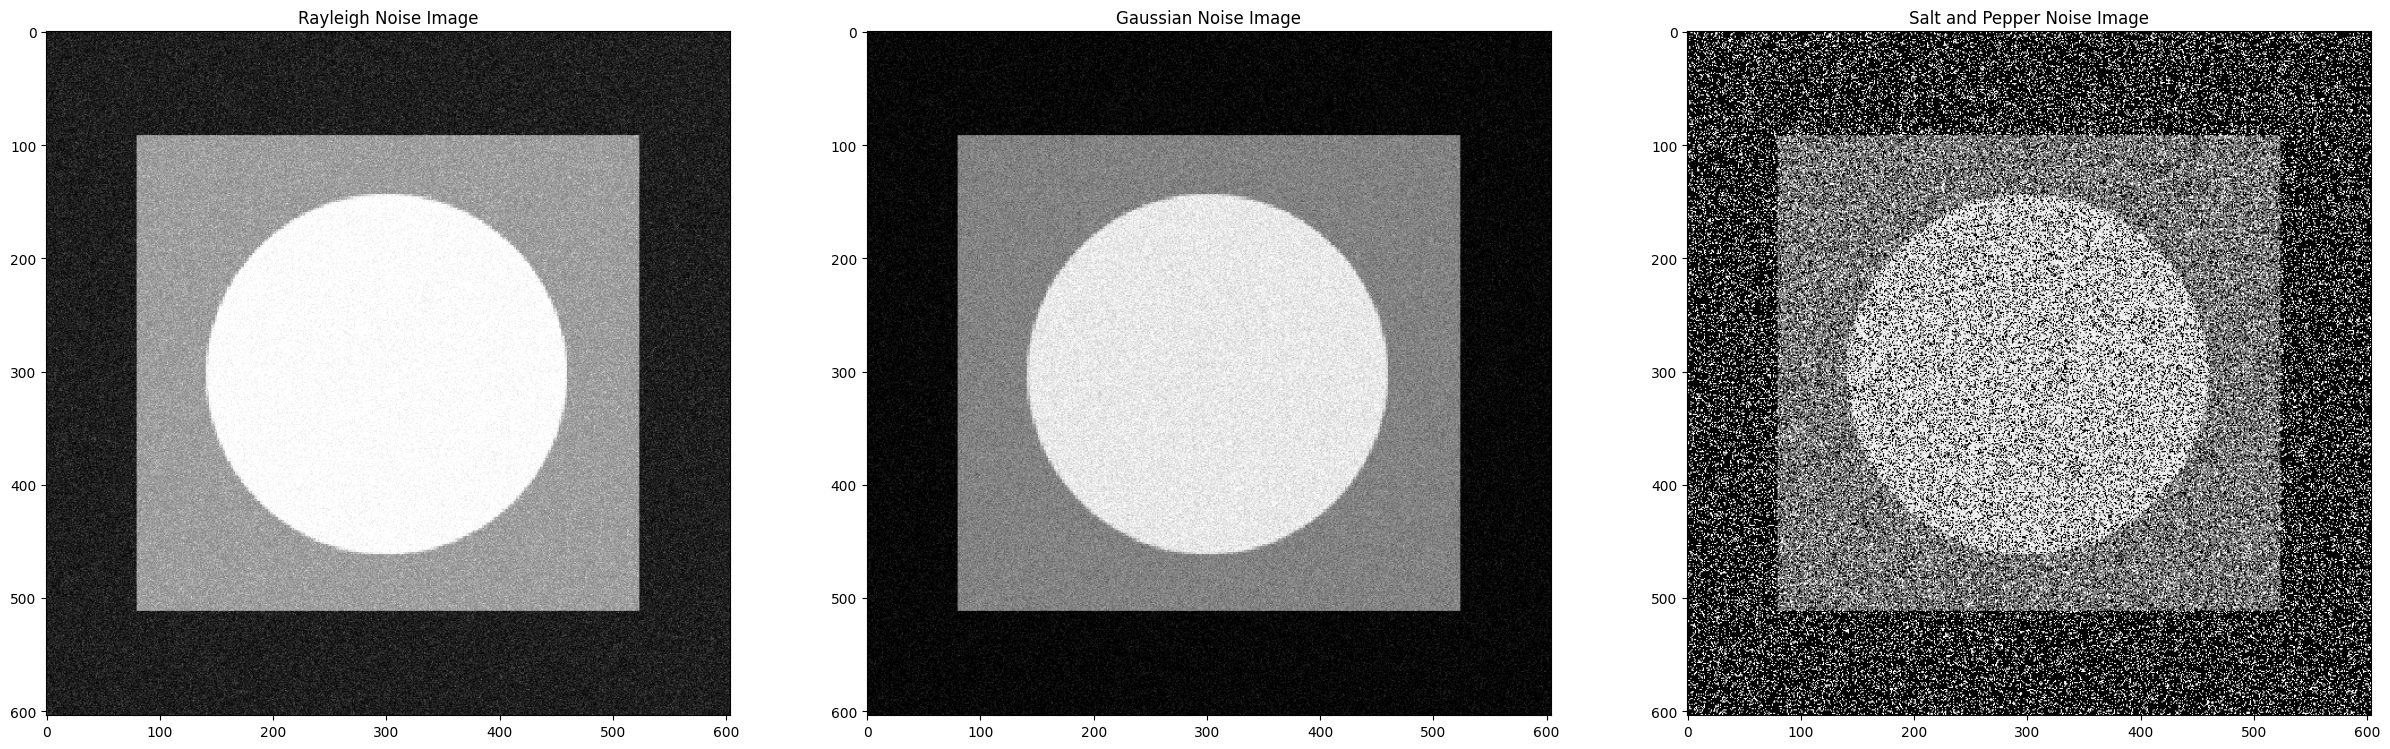

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.imshow(rayleigh_noise_image, cmap="gray")
plt.title("Rayleigh Noise Image")

plt.subplot(1, 3, 2)
plt.imshow(gaussian_noise_image, cmap="gray")
plt.title("Gaussian Noise Image")

plt.subplot(1, 3, 3)
plt.imshow(salt_and_pepper_noise_image, cmap="gray")
plt.title("Salt and Pepper Noise Image")

plt.show()

### 要求2

生成噪声图像的直方图。

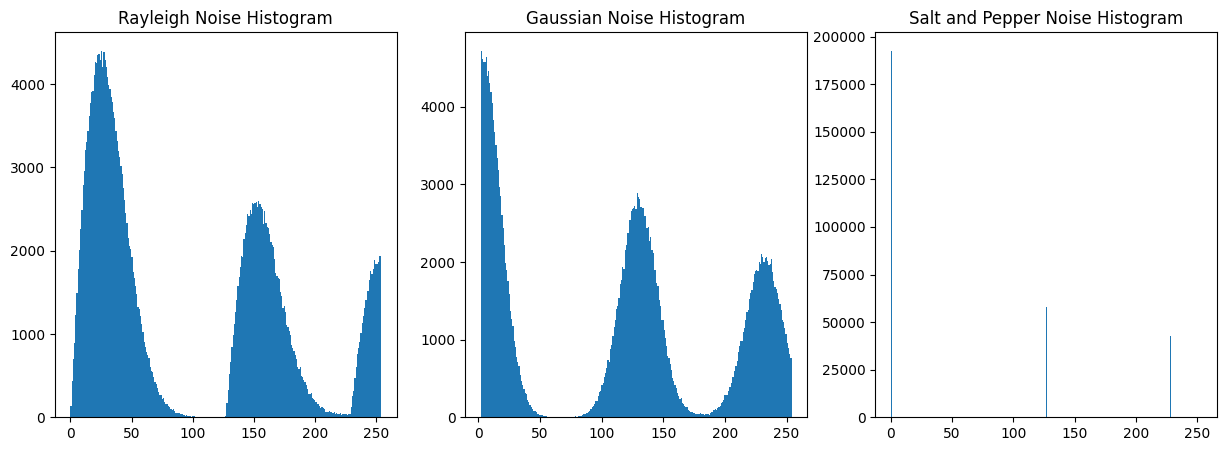

In [3]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(rayleigh_noise_image.flatten(), 255, [0, 254])
plt.title("Rayleigh Noise Histogram")

plt.subplot(1, 3, 2)
plt.hist(gaussian_noise_image.ravel(), 255, [2, 254])
plt.title("Gaussian Noise Histogram")

plt.subplot(1, 3, 3)
plt.hist(salt_and_pepper_noise_image.ravel(), 255, [0, 254])
plt.title("Salt and Pepper Noise Histogram")

plt.show()

## 5-2 含噪声图像处理

### 要求1

实现自适应中值滤波算法(adaptive median filter)，并和7×7中值滤波器比较。

In [4]:
image = cv2.imread("imgs/Lab5/circuitboard-saltandpep.tif", cv2.IMREAD_GRAYSCALE)


# 实现自适应中值滤波器（Adaptive Median Filter）
def adaptive_median_filter(image, window_size):
    filtered_image = np.copy(image)
    height, width = image.shape

    for i in range(height):
        for j in range(width):
            filtered_image[i, j] = adaptive_median_filter_pixel(
                image, i, j, window_size
            )

    return filtered_image


def adaptive_median_filter_pixel(image, i, j, window_size):
    height, width = image.shape
    window_radius = window_size // 2
    window = []

    for m in range(-window_radius, window_radius + 1):
        for n in range(-window_radius, window_radius + 1):
            if i + m >= 0 and i + m < height and j + n >= 0 and j + n < width:
                window.append(image[i + m, j + n])

    window.sort()
    window_median = window[len(window) // 2]
    window_min = window[0]
    window_max = window[-1]

    if window_min < window_median < window_max:
        pixel = image[i, j]
        if window_min < pixel < window_max:
            return pixel
        else:
            return window_median
    else:
        window_size += 2
        if window_size <= min(height, width):
            return adaptive_median_filter_pixel(image, i, j, window_size)
        else:
            return window_median


# 实现固定的 7x7 中值滤波器
def fixed_median_filter(image):
    filtered_image = cv2.medianBlur(image, 7)
    return filtered_image


adaptive_filtered_image = adaptive_median_filter(image, 3)

fixed_filtered_image = fixed_median_filter(image)

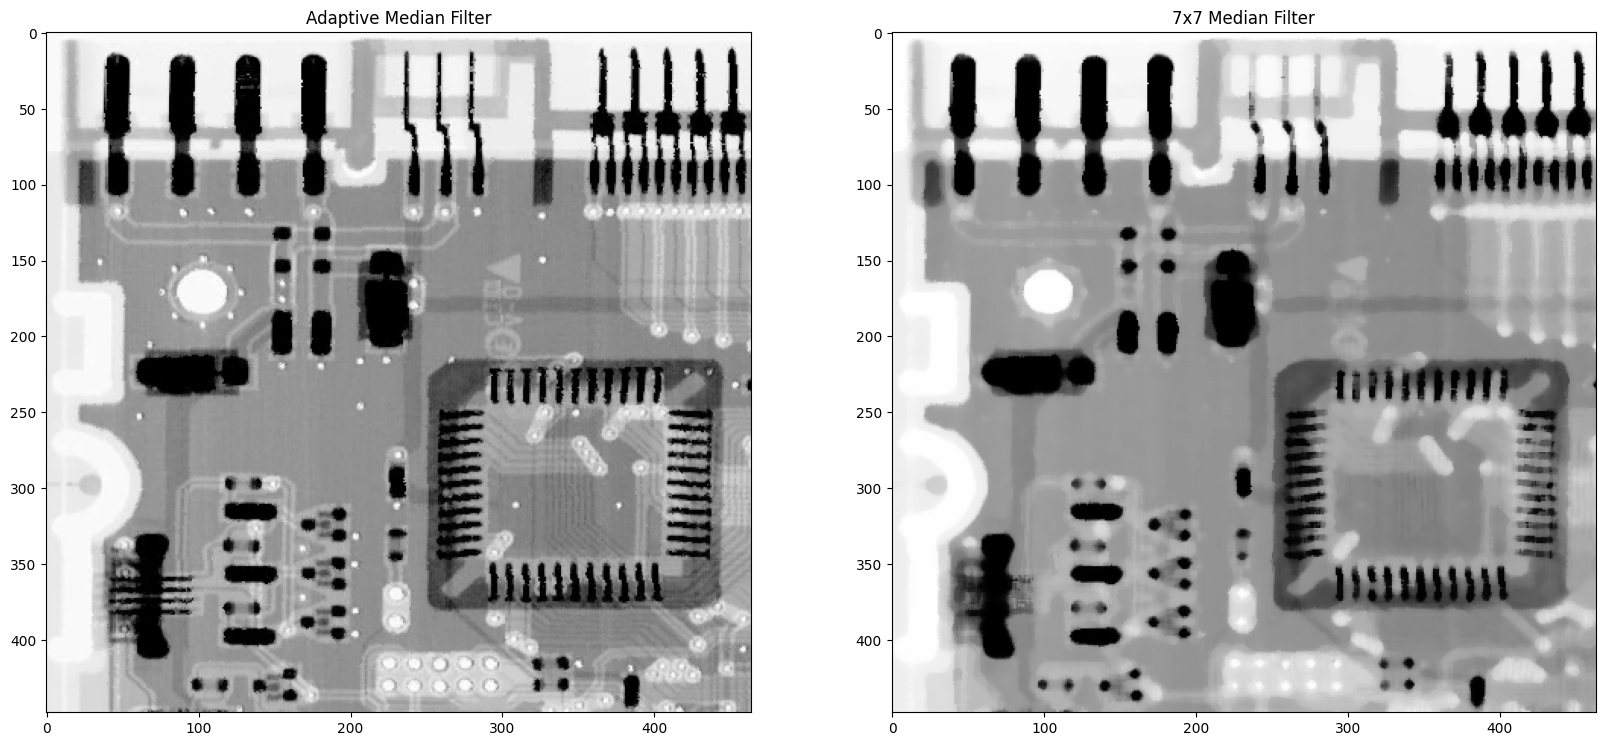

In [5]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(adaptive_filtered_image, cmap="gray")
plt.title("Adaptive Median Filter")

plt.subplot(1, 2, 2)
plt.imshow(fixed_filtered_image, cmap="gray")
plt.title("7x7 Median Filter")

plt.show()

### 要求2

采用图像复原技术中的维纳滤波器对运动模糊和被均值为0、方差为650的加性高斯噪声污染的图像进行处理；

$$
H(u, v)=\frac{T}{\pi(ua+vb)}\sin{(\pi(ua+vb))}e^{-j\pi(ua+vb)}
$$

其中，$a=b=0.1, T=1$

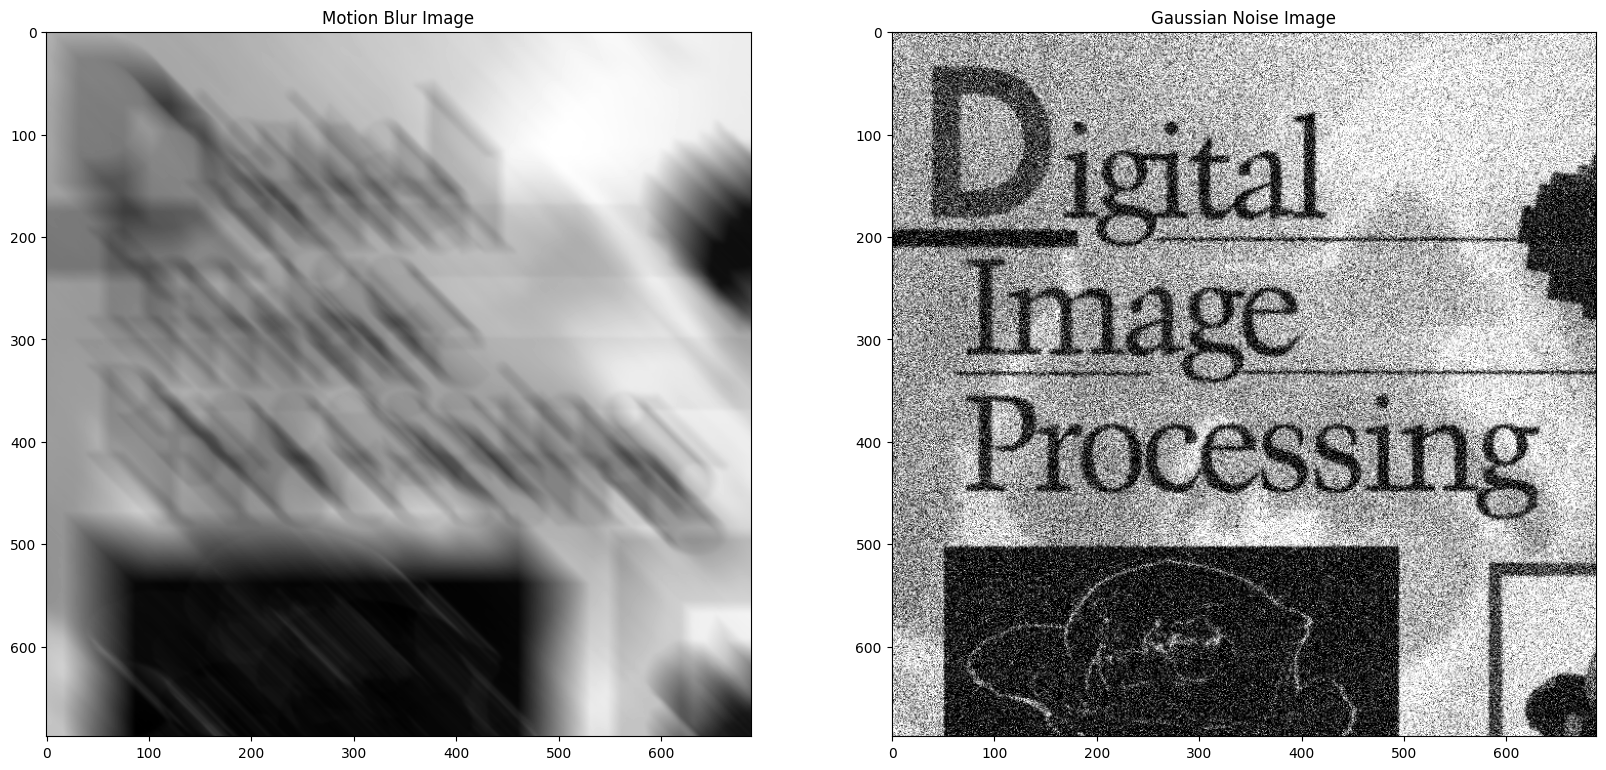

In [6]:
book_cover = cv2.imread("imgs/Lab5/book-cover.tif", cv2.IMREAD_GRAYSCALE)


def apply_motion_blur(image, kernel_size, angle):
    # 创建一个空的运动模糊核
    kernel = np.zeros((kernel_size, kernel_size))

    # 计算角度的弧度
    radian = angle

    # 计算运动模糊核的中心
    center = kernel_size // 2

    # 填充运动模糊核
    for i in range(kernel_size):
        x_offset = int(center + (i - center) * np.cos(radian))
        y_offset = int(center + (i - center) * np.sin(radian))
        if 0 <= x_offset < kernel_size and 0 <= y_offset < kernel_size:
            kernel[y_offset, x_offset] = 1

    # 归一化核
    kernel /= np.sum(kernel)

    # 应用卷积
    blurred_image = cv2.filter2D(image, -1, kernel)

    return blurred_image


motion_blur_image = apply_motion_blur(book_cover, kernel_size=100, angle=np.pi / 4)


# 施加Gaussian噪声
gaussian_noise_image = generate_gaussian_noise_image(motion_blur_image.shape, 0, 65.0, book_cover)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(motion_blur_image, cmap="gray")
plt.title("Motion Blur Image")
plt.subplot(1, 2, 2)
plt.imshow(gaussian_noise_image, cmap="gray")
plt.title("Gaussian Noise Image")
plt.show()

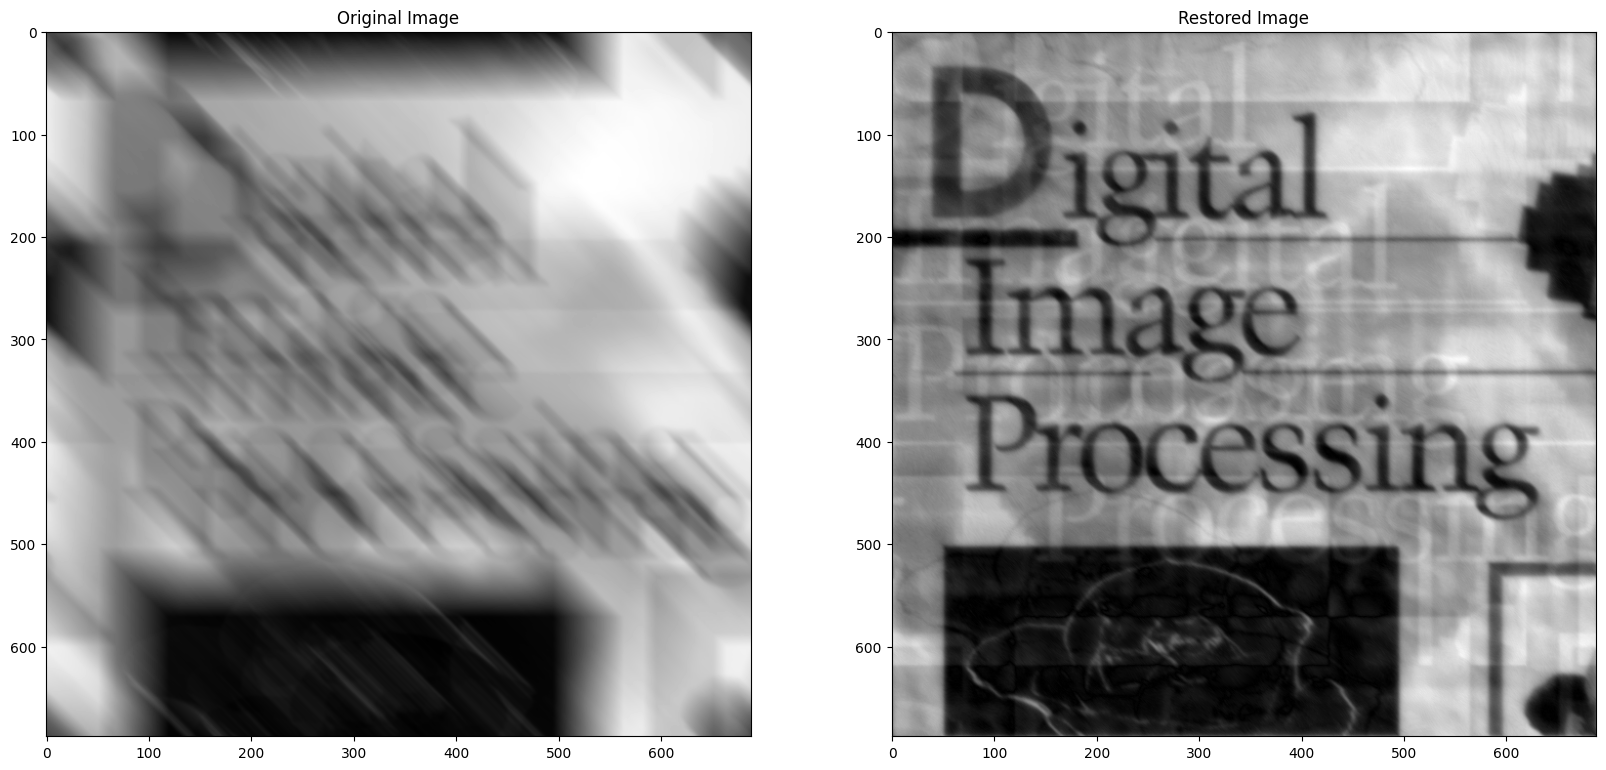

In [7]:
def calc_H(u, v, a, b, T):
    pi_term = np.pi * (u * a + v * b)
    if pi_term == 0:
        return T
    else:
        return (T / pi_term) * np.sin(pi_term) * np.exp(-1j * pi_term)


def create_motion_blur_filter(shape, a, b, T):
    H = np.zeros(shape, dtype=complex)
    rows, cols = shape[0], shape[1]
    for u in range(-rows // 2, rows // 2):
        for v in range(-cols // 2, cols // 2):
            H[u + rows // 2, v + cols // 2] = calc_H(u, v, a, b, T)
    return H


def wiener_filter_custom(G, H, K):
    H_abs_squared = np.abs(H) ** 2
    Wiener_filter = np.conj(H) / (H_abs_squared + K)
    F_hat = np.fft.fftshift(G) * Wiener_filter
    f_restored = np.fft.ifft2(np.fft.ifftshift(F_hat))
    return np.abs(f_restored)


K = 0.002
origin = cv2.imread("imgs/Lab5/book-cover-blurred.tif", 0)

H_filter = create_motion_blur_filter(origin.shape, a=0.1, b=0.1, T=1)

blurred_noisy_freq = np.fft.fft2(origin)

# 使用新的滤波器参数再次应用Wiener滤波
restored_image_final = wiener_filter_custom(blurred_noisy_freq, H_filter, K)

# 归一化修复后的图像，确保值在0到1之间
restored_image_final_normalized = (
    restored_image_final - np.min(restored_image_final)
) / (np.max(restored_image_final) - np.min(restored_image_final))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(origin, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(restored_image_final, cmap="gray")
plt.title("Restored Image")

plt.show()